In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle #变色
%matplotlib inline

from PIL import Image
from torchvision import transforms
from torch.utils import data

from sklearn.model_selection import StratifiedGroupKFold

import torch
from torch import nn
from torch import optim
import segmentation_models_pytorch as smp
from torch.cuda import amp #half和32位混合计算，极大提高batch_size

from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

import os
import re
import gc #垃圾回收

from tqdm import tqdm #进度条 for data in tqdm(range(100))

d:\Anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 问题

如何产生预测结果并生成rle编码

# 初步

数据介绍<p>
1. train下的每个caseXXX_dayYYY为一组图片，名字为"slice_切片编号_266_266_1.50_1.50.png"，其中"slice_切片编号"可在train.csv里获得；后面的数据前两个266，266是行列大小，后面1.50，1.50是行像素间距，列像素间距，单位mm，即像素大小<p>
这些图片是一个三维图像的各个横截面，已经介绍了各个横截面间隔3mm<p>
2. train.scv<br>
id:部分图片名<br>
class:大肠、小肠、胃<br>
segmentation:RLE压缩编码的一些信息(num1,a,num2,b)表示从num1有a个1值，从num2有b个1值，这就是分割图，只有0，1。1为标记部分，0为无用部分<br>
可解码查看效果，编码求损失

tensorboard查看图片

In [ ]:
%load_ext tensorboard

In [47]:
img = Image.open("E:\\DATA\\UW-Madison 胃肠道图像分割\\train\\case123\\case123_day20\\scans\\slice_0065_266_266_1.50_1.50.png")

writer = SummaryWriter()

writer.add_image(
    tag = 'p1',
    img_tensor = (transforms.ToTensor()(img))
)

writer.close()

图片展示

id                                       case123_day20_slice_0065
class                                                     stomach
segmentation    28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
Name: 194, dtype: object
(266, 266) (266, 266)


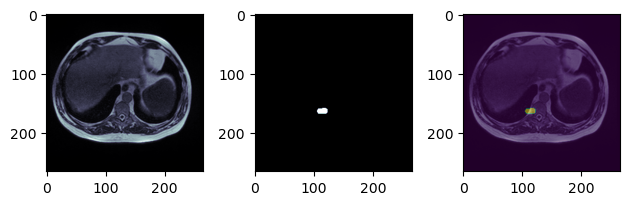

In [71]:
def Rle2Img(shape, rle: str):
    s = rle.split(" ")
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):#进行恢复
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


df = pd.read_csv("E:/DATA/UW-Madison 胃肠道图像分割/train.csv")
df = df[df['segmentation'].notna()]

row = df.iloc[0]
print(row)

img = Image.open("E:\\DATA\\UW-Madison 胃肠道图像分割\\train\\case123\\case123_day20\\scans\\slice_0065_266_266_1.50_1.50.png")
img = np.array(img, dtype=np.float32)
img /= np.max(img)
img *= 255.0
img.astype(np.uint8)

mask = Rle2Img((266,266),row['segmentation'])
print(img.shape,mask.shape)

plt.figure()
plt.subplot(1,3,1)
plt.imshow(img,cmap='bone')
plt.subplot(132)
plt.imshow(mask,cmap='bone')
plt.subplot(133)
plt.imshow(img,cmap='bone')
plt.imshow(mask, alpha=0.5)

plt.tight_layout()
plt.show()

表展示

In [72]:
df = pd.read_csv("E:\\DATA\\UW-Madison 胃肠道图像分割\\train.csv")
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [73]:
print(df['segmentation'][0],type(df['segmentation'][0]))

nan <class 'float'>


In [74]:
df[df['segmentation'].notna()].head()

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...


In [75]:
print(len(df[df['segmentation'].notna()]))
print(len(df[df['segmentation'].isna()]))

33913
81575


图片名

In [76]:
a = set()
for root, dirs, files in os.walk("E:\\DATA\\UW-Madison 胃肠道图像分割\\train\\"): #递归遍历
    for file in files:
        a.add(file[-21:-4])
print(a)

{'234_234_1.50_1.50', '360_310_1.50_1.50', '276_276_1.63_1.63', '266_266_1.50_1.50'}


注意事项

As there are overlaps between Stomach, Large Bowel & Small Bowel classes, this is a MultiLabel Segmentation task, so final activaion should be sigmoid instead of softmax.？？？？？？？？？？？？？？？？

# 开始（2D）

优化1：图片填充，而不是只resize。
- 则数据增强不使用旋转，相应地批次也从128减少到64<p>
- 效果：loss下降更快

## 初步处理

- 设备

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [ ]:
#gpu
!nvidia-smi

In [ ]:
#gpu
print(torch.cuda.memory.memory_summary())

- 基本参数

In [23]:
data_dir='E:/DATA/UW-Madison 胃肠道图像分割/'
models_dir = './models2d/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)
    print('models2d已创建')
else:
    for i in os.listdir(models_dir):
        c_path = os.path.join(models_dir, i)
        os.remove(c_path)
    print('models2d已存在，已将其清空')

train_batch_size=64
valid_batch_size=128
epochs=15

img_channels=1

img_shape = (320,384) #应被32整除，uNet限制

seed=101
def set_seed():
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

exp_name='exp1'
import shutil
if os.path.exists(exp_name):
    shutil.rmtree(exp_name)

modules_dir2d已存在


In [24]:
data_mode='debug'

- dataloader
1. 图片读出为(x,y),直接复制为(x,y,3),再化为0-1范围。之后经ToTensor可以变为(3,x,y)
2. mask为三张综合，化为(x,y,3)，再/255.0。之后经ToTensor可以变为(3,x,y)

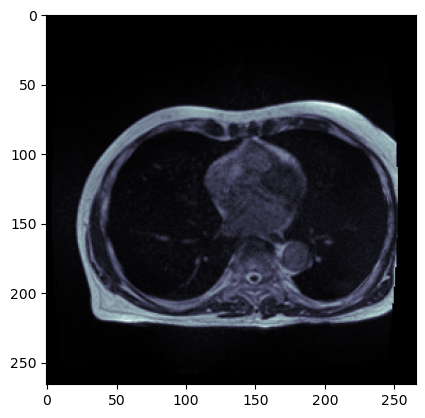

In [12]:
#例子

img = Image.open("E:/DATA/UW-Madison 胃肠道图像分割/train/case101/case101_day20/scans/slice_0047_266_266_1.50_1.50.png") #(x,y)或(x,y,3)
#转为ndarray处理
npimg = np.array(img, dtype=np.float32) #类型最好都是float32，形状保持不变
npimg /= np.max(npimg)
plt.imshow(npimg,cmap='bone')

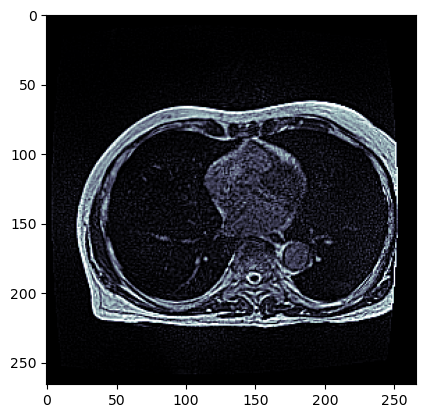

In [18]:
torimg = transforms.ToTensor()(npimg) #(x,y) or (x,y,1)->(1,x,y); (x,y,3)->(3,x,y)
torimg = transforms.RandomAdjustSharpness(10,1)(torimg)
plt.imshow(np.array(torimg).transpose([1,2,0]),cmap='bone')

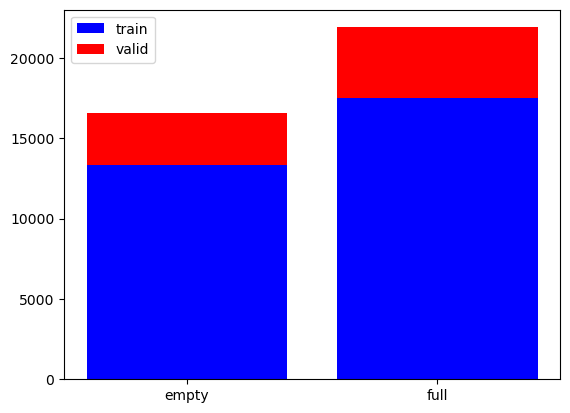

torch.Size([128, 1, 310, 360]) <class 'torch.Tensor'> torch.Size([128, 3, 310, 360]) <class 'torch.Tensor'> tensor(1.)
241
torch.Size([256, 1, 310, 360]) <class 'torch.Tensor'> torch.Size([256, 3, 310, 360]) <class 'torch.Tensor'> tensor(1.)
30


In [50]:
class DfProc(): #df的基本处理，注意ndarray保存后会变为str，所以这里不保存
    def __init__(self, data_mode='debug'):

        self.mode = data_mode
        assert self.mode in ['debug','mini','all'],print("mode值错误")

        self.__Set_Df()
        self.__split_data_by_mask()
        self.__split_train_valid()


    def __Set_Df(self):
        df = pd.read_csv(data_dir+"/train.csv")
        #新df
        lenn = int(len(df)/3)
        new_df = pd.DataFrame({
            'dir': [np.nan]*lenn,
            'filename': [np.nan]*lenn,
            'case': [np.nan]*lenn,
            'shape': [np.nan]*lenn,
            'large_bowel_seg': [np.nan]*lenn,
            'small_bowel_seg': [np.nan]*lenn,
            'stomach_seg': [np.nan]*lenn
        }) #内部自动转为字符串nan

        #case
        new_df['case'] = \
            df["id"][::3].str.split("_", expand=True)[0].str.split("e", expand=True)[1].reset_index(drop=True).astype(np.int32)

        #dir处理、filename初步处理
        filenames = df["id"][::3].str.split("_", expand=True)
        r1 = data_dir + "/data/train"
        r2 = filenames[0]
        r3 = filenames[0]+"_"+filenames[1]
        r4 = "scans"
        r5 = filenames[2]+"_"+filenames[3]
        dirr = r1+"/"+r2+"/"+r3+"/"+r4+"/"
        new_df['dir'] = list(dirr) #注意
        new_df['filename'] = list(r5+".*")

        #filename最终处理、shape处理
        new_filenames = []
        shapes = []
        for dirr, old_filename in zip(new_df['dir'], new_df['filename']):
            regex_pattern = old_filename
            regex = re.compile(regex_pattern)
            for root, dirs, files in os.walk(dirr):
                for file in files:
                    if regex.search(file):
                        new_filenames.append(file)
                        shapes.append((int(file.split("_")[3]),int(file.split("_")[2])))
                        break
        
        new_df['filename'] = new_filenames
        new_df['shape'] = shapes

        #mask处理
        large_bowels_df = [seg for seg in df['segmentation'][0::3]]
        small_bowels_df = [seg for seg in df['segmentation'][1::3]]
        stomachs_df = [seg for seg in df['segmentation'][2::3]]

        new_df['large_bowel_seg'] = large_bowels_df
        new_df['small_bowel_seg'] = small_bowels_df
        new_df['stomach_seg'] = stomachs_df

        self.df = new_df.reset_index(drop=True)

        #print(self.df.head(1))


    def __split_data_by_mask(self):
        self.df['empty']=[1]*len(self.df)
        self.df.loc[self.df[['large_bowel_seg','small_bowel_seg','stomach_seg']].notna().any(axis=1),'empty']=0
        self.df.loc[self.df[['large_bowel_seg','small_bowel_seg','stomach_seg']].isna().all(axis=1),'empty']=1

        #print(len(self.df[self.df['empty']==1]),len(self.df[self.df['empty']==0]))

    
    def __split_train_valid(self):
        self.df['fold']=[-1]*len(self.df)
        skf = StratifiedGroupKFold(5)
        for i, (train_i,valid_i) in enumerate(skf.split(self.df,self.df['empty'],groups=self.df['case'])):
            self.df.loc[valid_i,'fold'] = i+1

        self.train_df = self.df[self.df['fold']!=1]
        self.valid_df = self.df[self.df['fold']==1]

        if self.mode == 'debug':
            self.train_df = self.train_df[:train_batch_size*2]
            self.valid_df = self.valid_df[:valid_batch_size*1]
        elif self.mode == 'mini':
            self.train_df = self.train_df[:int(len(self.train_df)*0.3)]
            self.valid_df = self.valid_df[:int(len(self.valid_df)*0.3)]
        else:
            pass

        self.train_df.reset_index(inplace=True,drop=True)
        self.valid_df.reset_index(inplace=True,drop=True)
        
        train = [
            len(self.train_df[self.train_df['empty']==0]),
            len(self.train_df[self.train_df['empty']==1])
            ]
        plt.bar(['empty','full'], train, bottom=0, color='b')
        valid = [
            len(self.valid_df[self.valid_df['empty']==0]),
            len(self.valid_df[self.valid_df['empty']==1])
            ]
        plt.bar(['empty','full'], valid, bottom=np.array(train), color='r')

        plt.legend(['train','valid'])
        plt.show()



class MyDataSet(data.Dataset): #重写data.Dataset类，则DataLoader可用
    def __init__(self, dfProc, kind, transforms=None):
        self.kind = kind
        if kind == 'train':
            self.df = dfProc.train_df
        elif kind == 'valid':
            self.df = dfProc.valid_df
        elif kind == 'origin':
            self.df = dfProc.df
        else:
            raise ValueError('kind值错误')

        self.transforms = transforms

    
    def __Rle2Img(self, rle, shape):
        if type(rle) != str:
            return np.zeros(shape)
        
        s = rle.split(" ")
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]

        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):#进行恢复
            img[lo:hi] = 1
        return img.reshape(shape)
    

    def __getitem__(self, index):
        row = self.df.iloc[index]

        img = Image.open(row['dir']+row['filename'])#(x,y)或(x,y,3)，此时为(x,y)
        img = np.array(img, dtype=np.float32)
        if img_channels == 3:
            img = np.tile(img[...,None], [1, 1, 3]) #(x,y)->(x,y,3,1)->(x,y,3)
        else:
            img = img[:,:,np.newaxis] #(x,y)->(x,y,1)
        img /= np.max(img)

        mask = np.zeros((3,)+row['shape'])
        mask[0] = self.__Rle2Img(row['large_bowel_seg'], row['shape'])
        mask[1] = self.__Rle2Img(row['small_bowel_seg'], row['shape'])
        mask[2] = self.__Rle2Img(row['stomach_seg'], row['shape'])
        mask = mask.astype(np.float32).transpose([1,2,0]) #(x,y,3)

        if self.kind=='train':
            img = train_transforms[0](img).detach().numpy().transpose([1,2,0]) #(x,y,img_channels)
            #同时旋转
            d_img =  img.transpose([2,0,1]) #(img_channel,x,y)
            d_mask = mask.transpose([2,0,1]) #(3,x,y)
            
            data = np.vstack([d_img,d_mask]).transpose([1,2,0]) #(x,y,img_channel+3)
            data = self.transforms[1](data) #(img_channel+3,x,y)
            img,mask = data[:-3],data[-3:]

            return img, mask
        else:
            d_img =  img.transpose([2,0,1]) #(img_channel,x,y)
            d_mask = mask.transpose([2,0,1]) #(3,x,y)
            data = np.vstack([d_img, d_mask]).transpose([1,2,0]) #(x,y,img_channel+3)

            data = self.transforms(data) #(img_channel+3,x,y)
            img,mask = data[:-3],data[-3:]

            return img, mask

        
    def __len__(self):
        return len(self.df)


#形状变化
class ChangeShape(object):
    def __init__(self, shape):
        self.shape = shape

    def __call__(self, img): #在这里对数据进行处理
        """
        Args:
            img : 3d tensor
        Returns:
            3d tensor
        """
        old_shape = img.shape[1:]
        assert old_shape[0]<=self.shape[0] and old_shape[1]<=self.shape[1],print(old_shape)
        west = (self.shape[1]-old_shape[1])//2
        north = (self.shape[0]-old_shape[0])//2
        east = (self.shape[1]-old_shape[1]+1)//2
        south = (self.shape[0]-old_shape[0]+1)//2

        return transforms.Pad((west,north,east,south))(img) #西北东南顺序填充指定个数

train_transforms = [
    transforms.Compose(
        [
            transforms.ToTensor(), #二维时(x,y)->(1,x,y)，高于二维时(x,y,channels(1,2,..))->(channels,x,y)。如果数据是uint8，则会归一化

            #数据增强
            transforms.RandomAdjustSharpness(10,0.9) #锐化
        ]
    ), #img
    transforms.Compose(
        [
            transforms.ToTensor(),

            #数据增强
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            #transforms.RandomRotation(60,expand=True), #会增大图片
            #transforms.Resize((224,224)), #三维也可以这样用
            ChangeShape(img_shape),
        ]
    ), #img+mask
]
valid_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        #transforms.Resize((224,224)),
        ChangeShape(img_shape),
    ]
)

dfProc = DfProc(data_mode=data_mode)

train_data = MyDataSet(dfProc, kind='train', transforms=train_transforms)
train_dataloader = data.DataLoader(
    train_data, 
    batch_size=train_batch_size, 
    pin_memory=True, 
    #num_workers=2, 
    shuffle=True, 
    drop_last=False
    )

valid_data = MyDataSet(dfProc, kind='valid', transforms=valid_transform)
valid_dataloader = data.DataLoader(
    valid_data, 
    batch_size=valid_batch_size,
    pin_memory=True, 
    #num_workers=2, 
    shuffle=False, 
    drop_last=False
    )

for img,mask in train_dataloader:
    print(img.shape,type(img),mask.shape,type(mask),torch.max(img))
    break
print(len(train_dataloader))

for img,mask in valid_dataloader:
    print(img.shape,type(img),mask.shape,type(mask),torch.max(img))
    break
print(len(valid_dataloader))

- Unet

In [6]:
class DownsampleLayer(nn.Module):
    def __init__(self,in_ch, out_ch):
        super(DownsampleLayer, self).__init__()
        self.Conv_BN_ReLU_2=nn.Sequential(
            nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.downsample=nn.Sequential(
            nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self,x):
        """
        :param x:
        :return: out输出到深层，out_2输入到下一层，
        """
        out=self.Conv_BN_ReLU_2(x)
        out_2=self.downsample(out)
        return out,out_2

class UpSampleLayer(nn.Module):
    def __init__(self,in_ch,out_ch):
        # 512-1024-512
        # 1024-512-256
        # 512-256-128
        # 256-128-64
        super(UpSampleLayer, self).__init__()
        self.Conv_BN_ReLU_2 = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch*2, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(out_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_ch*2, out_channels=out_ch*2, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(out_ch*2),
            nn.ReLU()
        )
        self.upsample=nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_ch*2,out_channels=out_ch,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self,x,out):
        '''
        :param x: 输入卷积层
        :param out:与上采样层进行cat
        :return:
        '''
        x_out=self.Conv_BN_ReLU_2(x)
        x_out=self.upsample(x_out)
        cat_out=torch.cat((x_out,out),dim=1)
        return cat_out

class UNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=3):
        super(UNet, self).__init__()
        out_channels=[2**(i+6) for i in range(5)] #[64, 128, 256, 512, 1024]
        #下采样
        self.d1=DownsampleLayer(input_channels,out_channels[0])#3-64
        self.d2=DownsampleLayer(out_channels[0],out_channels[1])#64-128
        self.d3=DownsampleLayer(out_channels[1],out_channels[2])#128-256
        self.d4=DownsampleLayer(out_channels[2],out_channels[3])#256-512
        #上采样
        self.u1=UpSampleLayer(out_channels[3],out_channels[3])#512-1024-512
        self.u2=UpSampleLayer(out_channels[4],out_channels[2])#1024-512-256
        self.u3=UpSampleLayer(out_channels[3],out_channels[1])#512-256-128
        self.u4=UpSampleLayer(out_channels[2],out_channels[0])#256-128-64
        #输出
        self.o=nn.Sequential(
            nn.Conv2d(out_channels[1],out_channels[0],kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(out_channels[0]),
            nn.ReLU(),
            nn.Conv2d(out_channels[0], out_channels[0], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels[0]),
            nn.ReLU(),
            nn.Conv2d(out_channels[0],output_channels,3,1,1),
        )
    def forward(self,x):
        out_1,out1=self.d1(x)
        out_2,out2=self.d2(out1)
        out_3,out3=self.d3(out2)
        out_4,out4=self.d4(out3)
        out5=self.u1(out4,out_4)
        out6=self.u2(out5,out_3)
        out7=self.u3(out6,out_2)
        out8=self.u4(out7,out_1)
        out=self.o(out8)
        return out


uNet = UNet(img_channels,3)

summary(uNet, input_size=(img_channels,224,224),batch_size=train_batch_size)

for name, params in uNet.named_parameters():
    print(name, params.shape)
    break

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]             640
       BatchNorm2d-2        [128, 64, 224, 224]             128
              ReLU-3        [128, 64, 224, 224]               0
            Conv2d-4        [128, 64, 224, 224]          36,928
       BatchNorm2d-5        [128, 64, 224, 224]             128
              ReLU-6        [128, 64, 224, 224]               0
            Conv2d-7        [128, 64, 112, 112]          36,928
       BatchNorm2d-8        [128, 64, 112, 112]             128
              ReLU-9        [128, 64, 112, 112]               0
  DownsampleLayer-10  [[-1, 64, 224, 224], [-1, 64, 112, 112]]               0
           Conv2d-11       [128, 128, 112, 112]          73,856
      BatchNorm2d-12       [128, 128, 112, 112]             256
             ReLU-13       [128, 128, 112, 112]               0
           Conv2d-14    

d:\Anaconda\envs\pytorch\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in long_scalars
  total_output += np.prod(summary[layer]["output_shape"])


In [ ]:
uNet = smp.Unet(
        encoder_name='efficientnet-b1',      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=img_channels,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    
summary(uNet, input_size=(img_channels,224,224),batch_size=train_batch_size)

for name, params in uNet.named_parameters():
    print(name, params.shape)
    break

- loss

In [7]:
def loss_func(pre_y, y):
    loss = 0.5*smp.losses.SoftBCEWithLogitsLoss()(pre_y,y)+\
    0.5*smp.losses.TverskyLoss(mode='multilabel', log_loss=False)(pre_y,y)
    return loss

- optim,scheduler

In [8]:
optimizer = optim.Adam(uNet.parameters(),lr=0.002)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=241*epochs+10, 
    eta_min=1e-6
    )#整个训练过程完成max->min

- 训练类

In [9]:
class Runner():
    def __init__(
        self,

        net,device,
        loss_func,optimizer,scheduler,

        train_dataloader, valid_dataloader,

        smw
        ):
        self.net = net
        self.device = device
        
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.scheduler = scheduler

        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader

        self.smw = smw

        self.__pre_proc()


    def __pre_proc(self):
        self.net = self.net.to(self.device)
        
        self.train_loss = {}
        self.valid_loss = {}
        
    def __clear_train_result(self):
        self.train_loss = {}
        self.valid_loss = {}
    
    
    def get_loss(self, kind):
        if kind == 'train':
            return self.train_loss
        elif kind == 'valid':
            return self.valid_loss
        else:
            raise ValueError("kind值错误")

    
    def set_net(self, epoch):
        """
        从文件读出参数

        Args:
            epoch: 第几轮的参数
        """
        path = models_dir + "/epoch_{}.pkl".format(epoch)
        net_params = torch.load(path)
        self.net.load_state_dict(net_params)


    def save_net(self, epoch):
        path = models_dir + "/epoch_{}.pkl".format(epoch)
        net_params = self.net.state_dict()
        torch.save(net_params, path)
        
        
    """训练相关"""
    def train_epoch(self, epoch):
        self.net.train()
        scaler = amp.GradScaler()
        
        runing_loss = 0 #统计本epoch的平均loss
        data_size = 0
        pbar = tqdm(enumerate(self.train_dataloader), total=len(self.train_dataloader), desc=f'epoch_{epoch} training')
        for i, (img, mask) in pbar:      
            img = img.to(self.device)
            mask = mask.to(self.device)
            
            with amp.autocast():
                res = self.net(img)
                loss = self.loss_func(res, mask)
            scaler.scale(loss).backward()
            
            if i%1==0:
                scaler.step(self.optimizer)#128张图更新一次
                scaler.update()
                self.optimizer.zero_grad()
                if self.scheduler is not None:
                    self.scheduler.step() #同时更新lr
                
            runing_loss += float(loss)*train_batch_size
            data_size += train_batch_size
            
            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix(
                runing_loss=f'{runing_loss/data_size:0.4f}',
                lr=f'{current_lr:0.4f}',
                gpu_mem=f'{mem:0.2f} GB'
            )

        torch.cuda.empty_cache()
        gc.collect()
 
        self.train_loss['epoch_'+str(epoch)] = runing_loss/data_size
        self.save_net(epoch)

    @torch.no_grad()
    def valid_epoch(self, epoch=0):
        self.net.eval()

        runing_loss = 0
        data_size = 0
        pbar = tqdm(enumerate(self.valid_dataloader), total=len(self.valid_dataloader), desc='epoch_{} val'.format(epoch))
        for i, (img, mask) in pbar:
            img = img.to(self.device)
            mask = mask.to(self.device)

            with amp.autocast():
                res = self.net(img)
                loss = self.loss_func(res, mask)
            runing_loss += float(loss)*valid_batch_size
            data_size += valid_batch_size

        torch.cuda.empty_cache()
        gc.collect()

        self.valid_loss['epoch_'+str(epoch)] = runing_loss/data_size


    def train(self):
        self.__clear_train_result()
        for epoch in range(epochs):
            self.train_epoch(epoch)
            self.valid_epoch(epoch)

            self.__smw_proc(epoch)
    
    def __smw_proc(self,epoch):
        self.smw.add_scalars(
            main_tag='datas/loss',
            tag_scalar_dict={
                "train_loss":self.train_loss[f"epoch_{epoch}"],
                "valid_loss":self.valid_loss[f"epoch_{epoch}"],
                },
            global_step=epoch
        )
        self.smw.add_scalar(
            tag='datas/lr',
            scalar_value=optimizer.param_groups[0]['lr'],
            global_step=epoch
        )

        imgs,masks,pred_masks = self.__get_result('train',2)
        for i in range(imgs.shape[0]):
            dis_imgs = np.stack([i for i in imgs[i]]+[i for i in masks[i]]+[i for i in pred_masks[i]],axis=0)
            dis_imgs = dis_imgs[:,np.newaxis]
            self.smw.add_images(
                tag=f"epoch_{epoch}/train/{i}",
                img_tensor=dis_imgs
            )
        imgs,masks,pred_masks = self.__get_result('valid',2)
        for i in range(imgs.shape[0]):
            dis_imgs = np.stack([i for i in imgs[i]]+[i for i in masks[i]]+[i for i in pred_masks[i]],axis=0)
            dis_imgs = dis_imgs[:,np.newaxis]
            self.smw.add_images(
                tag=f"epoch_{epoch}/valid/{i}",
                img_tensor=dis_imgs
            )
            
    @torch.no_grad()
    def __get_result(self,dataset,num):
        assert num<train_batch_size and num<valid_batch_size,print('num太大')
        if dataset == 'train':
            ds = self.train_dataloader
        elif dataset == 'valid':
            ds = self.valid_dataloader
        else:
            raise ValueError("dataset值错误")

        display_imgs = torch.zeros((num,img_channels)+img_shape)
        display_masks = torch.zeros((num,3)+img_shape)
        num2=0
        for imgs, masks in ds:
            for i in range(masks.shape[0]):
                if masks[i].sum()!=0:
                    display_imgs[num2] = imgs[i]
                    display_masks[num2] = masks[i]
                    num2+=1
                if num2==num:
                    break
            if num2==num:
                break
        display_imgs = display_imgs.to(self.device)
        display_masks = display_masks.to(self.device)
        with amp.autocast():
            pred_display_masks = self.net(display_imgs) #4d
        pred_display_masks = nn.Sigmoid()(pred_display_masks) #注意网络中没有这步，但是损失函数包含了这步，所以要加上
        pred_display_masks = (pred_display_masks>=0.5).float()
        display_imgs = display_imgs.detach().cpu().numpy()
        display_masks = display_masks.detach().cpu().numpy()
        pred_display_masks = pred_display_masks.detach().cpu().numpy()

        return display_imgs,display_masks,pred_display_masks

## 运行

设置

In [ ]:
with SummaryWriter(exp_name) as smw:
    runner = Runner(
        uNet,device,
        loss_func,optimizer,scheduler,
        train_dataloader,valid_dataloader,
        smw,
        )

    runner.train()

选择最好的模型

In [ ]:
valid_loss = runner.get_loss(kind='valid')

min_loss = np.inf
for key,value in valid_loss.items():
    if value<min_loss:
        min_loss = value
        if key[-2]=='1':
            best_epoch = int(key[-2:])
        else:
            best_epoch = int(key[-1])

print(f"best_epoch is {best_epoch}")
runner.set_net(best_epoch)

# 开始（2.5D）

即输入图片通道为3，3张图分别同一case的同一天切片号为(1,3,5)、(2,4,6)、(3,5,7)的图<p>
其他基本不变